In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import pickle
import numpy as np
import gc
from sklearn.model_selection import train_test_split

In [2]:
class ModelStatistics():
    def __init__(self,path_to_model_info: str, info_format: str, transpose: bool = False):
        self.format = info_format
        self.transpose = transpose
        self.path = path_to_model_info
        
        self.df = self.clean_and_reorder()
        self.activation_types = self.df['activation'].unique()
        self.loss_types = self.df['loss_function'].unique()
        self.dropout_types = self.df['dropout'].unique()
        self.architecture_types = self.df['architecture'].unique()
        self.optimizer_types = self.df['optimizer'].unique()
        
        
        
    def generate_dataframe(self, sep: str = ','):
        if self.format == 'pkl' or self.format == 'pickle':
            with open(path_to_models_statistics,"rb") as f:
                model_statistics = pickle.load(f)
            df = pd.DataFrame.from_dict(model_statistics)
            
        elif self.format == 'csv':
            df = pd.read_csv(path_to_model_info, sep = sep)
            
        elif self.format == 'hdf' or self.format == 'h5':
            df = pd.read_hdf(path_to_model_info)
            
        else:
            raise "Not suported format error"
            
        if self.transpose == True:
            df = df.T
        
        return df
    
    def standard_cleaner(self, df: pd.DataFrame) -> pd.DataFrame:
        
        df_reset = df.reset_index()
        df_split = df_reset['index'].str.split('_', expand=True)
        
        df_split.drop(0, axis=1, inplace=True)
        df_split.drop(6, axis=1, inplace=True)
        
        df_split.rename(columns={1:'architecture', 2:'activation', 3:'dropout', 4:'optimizer', 5:'loss_function'}, inplace=True)
        
        df_split['dropout'] = df_split['dropout'].str.replace("Drop", "").astype(float)
        df_final = pd.concat([df_split, df_reset], axis = 1)
        
        df_final = df_final.astype({'architecture':str,
                                    'activation':str,
                                    'dropout':float,
                                    'optimizer':str,
                                    'loss_function':str,
                                    'index':str,
                                    'best_loss':float,
                                    'time':float,
                                    'total_epochs':int})
        return df_final
    
    
    def clean_and_reorder(self, personalized_cleaner_function = None) -> pd.DataFrame:
        
        df = self.generate_dataframe()
        
        if personalized_cleaner_function != None:
            df = personalized_cleaner_function(df)
        
        else:
            df = self.standard_cleaner(df)
        
        return df
    
        
    def get_top_paramters(self, best_loss_or_time:str, hyperparamiter_info: str, k: int):
        all_top_k = {}
        hyperparamiters = self.df[hyperparamiter_info].unique()
        
        for hyperparamiter in hyperparamiters:
            all_top_k_loss = {}
            for loss in self.loss_types:
                df = self.df[self.df['loss_function'] == loss]
                df = df[df[hyperparamiter_info] == hyperparamiter]
                lines = self.df.iloc[df[best_loss_or_time].nsmallest(k).index]
                all_top_k_loss[loss] = lines
            all_top_k[hyperparamiter] = all_top_k_loss
        
        return all_top_k
    
    def get_top_for_loss_type(self, best_loss_or_time:str):
        all_top_k_loss = {}
        for loss in self.loss_types:
            df = self.df[self.df['loss_function'] == loss]
            lines = self.df.iloc[df[best_loss_or_time].nsmallest(k).index]
            all_top_k_loss[loss] = lines
        return all_top_k_loss
    
    def get_cleaned_dataframe(self):
        return self.df
    
    
    def generate_dataframe_from_dict(self,info: dict):
        data = []
        for optimizer, metrics in info.items():
            for metric, details in metrics.items():
                data.append(details)
    
        return pd.concat(data, axis=0)
    
    def get_top_k_losses_for_optmizer(self, k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('best_loss', 'optimizer', k)
    
        return self.generate_dataframe_from_dict(info)

    def get_not_learning_models_MAPE(self) -> pd.DataFrame:
        return self.df[(self.df["best_loss"] > 0.9) & (self.df["best_loss"] < 1.0)]
    
    def get_top_k_losses_for_dropout(self, k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('best_loss', 'dropout', k)
        
        return self.generate_dataframe_from_dict(info)
    
    def get_top_k_losses_for_activation(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('best_loss', 'activation', k)
    
        return self.generate_dataframe_from_dict(info)

    def get_top_k_losses_for_architecture(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('best_loss', 'architecture', k)
        
        return self.generate_dataframe_from_dict(info)

    def get_top_k_losses_for_loss_function(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_for_loss_type('best_loss', k)
        
        return self.generate_dataframe_from_dict(info)

    def get_top_k_times_for_optimizer(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('time', 'optimizer', k)
        
        return self.generate_dataframe_from_dict(info)

    def get_top_k_times_for_dropout(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('time', 'dropout', k)
        
        return self.generate_dataframe_from_dict(info)

    def get_top_k_times_for_activation(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('time', 'activation', k)
        
        return self.generate_dataframe_from_dict(info)

    def get_top_k_times_for_architecture(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_paramters('time', 'architecture', k)
        
        return self.generate_dataframe_from_dict(info)

    def get_top_k_times_for_loss_function(self,  k:int = 5) -> pd.DataFrame:
        info = self.get_top_for_loss_type('time', k)
        
        return self.generate_dataframe_from_dict(info)
    
    def get_avrg_time(self,list_group: list):
        df = self.df.groupby(list_group)['time'].mean().reset_index()
        return df.sort_values(by=['time'], ascending=True)

In [3]:
path_to_models_statistics = "savedBenchmarksInference/results.pkl"
path_to_model = "savedModels/"
path_to_data ="data/dados.h5"

In [4]:
#ms = ModelStatistics(path_to_models_statistics, 'pkl', True)

In [5]:
class ModelPlots(ModelStatistics):
    def __init__(self, path_to_model_info: str, path_to_model: str, path_to_original_data: str, info_format: str, transpose: bool = False):
        super().__init__(path_to_model_info, info_format, transpose)
        self.path_to_model = path_to_model
        self.original_df = pd.read_hdf(path_to_original_data)
        self.y = self.original_df["perf"]
        self.original_df.drop(columns= ["perf", "active_options"], inplace = True)
        self.x = self.original_df
        self.X_train , self.X_test , self.y_train , self.y_test = train_test_split(self.x, self.y, test_size=0.2, random_state=42)
        self.X_train , self.X_val , self.y_train , self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.1, random_state=42)
        
        
    def plot_top_k_losses_for_optmizer(self, k:int = 5):
        return self.get_top_k_losses_for_optmizer(k)
        
    def plot_model_prediction_in_actual_data(self, model_name: str):
        plt.plot(self.y[:100], color = 'b')
        model = torch.load(self.path_to_model+model_name)
        tensor = torch.from_numpy(self.X_test[:100].to_numpy()).type(torch.float).to('cuda')
        pred = model(tensor)
        pred = torch.Tensor.cpu(pred).detach().numpy()
        plt.plot(pred, color='r', linestyle = 'dashed')
        plt.show()
        
    def print_df(self):
        return self.original_df
    
    
        
    
    

In [6]:
mp = ModelPlots(path_to_models_statistics,path_to_model,path_to_data, 'pkl', True)

In [7]:
mp.df.iloc[mp.df['best_loss'].nsmallest(5).index]

,architecture,activation,dropout,optimizer,loss_function,index,best_loss,time,total_epochs
82,Straight2,PReLU,0.20,AdamW,MAPE,Model_Straight2_PReLU_Drop0.2_AdamW_MAPE_,0.086064,784.767005,99
59,Straight2,PReLU,0.00,AdamW,MAPE,Model_Straight2_PReLU_Drop0.0_AdamW_MAPE_,0.086784,784.585685,99
442,Straight2,PReLU,0.15,Adam,MAPE,Model_Straight2_PReLU_Drop0.15_Adam_MAPE_,0.086846,799.968651,99
276,Straight2,PReLU,0.10,AdamW,MAPE,Model_Straight2_PReLU_Drop0.1_AdamW_MAPE_,0.087117,797.053718,99
308,Straight2,PReLU,0.15,AdamW,MAPE,Model_Straight2_PReLU_Drop0.15_AdamW_MAPE_,0.088712,799.378512,99


In [8]:
mp.plot_top_k_losses_for_optmizer()

,architecture,activation,dropout,optimizer,loss_function,index,best_loss,time,total_epochs
439,Straight2,RReLU,0.10,AdamW,MSE,Model_Straight2_RReLU_Drop0.1_AdamW_MSE_,1.454471e+15,810.947791,99
97,Straight2,RReLU,0.20,AdamW,MSE,Model_Straight2_RReLU_Drop0.2_AdamW_MSE_,1.496529e+15,783.904764,99
42,Straight2,PReLU,0.10,AdamW,MSE,Model_Straight2_PReLU_Drop0.1_AdamW_MSE_,1.507754e+15,793.931559,99
277,Straight2,LeakyReLU,0.10,AdamW,MSE,Model_Straight2_LeakyReLU_Drop0.1_AdamW_MSE_,1.508834e+15,797.267011,99
46,Straight2,LeakyReLU,0.00,AdamW,MSE,Model_Straight2_LeakyReLU_Drop0.0_AdamW_MSE_,1.517918e+15,791.696021,99
82,Straight2,PReLU,0.20,AdamW,MAPE,Model_Straight2_PReLU_Drop0.2_AdamW_MAPE_,8.606354e-02,784.767005,99
59,Straight2,PReLU,0.00,AdamW,MAPE,Model_Straight2_PReLU_Drop0.0_AdamW_MAPE_,8.678368e-02,784.585685,99
276,Straight2,PReLU,0.10,AdamW,MAPE,Model_Straight2_PReLU_Drop0.1_AdamW_MAPE_,8.711743e-02,797.053718,99
308,Straight2,PReLU,0.15,AdamW,MAPE,Model_Straight2_PReLU_Drop0.15_AdamW_MAPE_,8.871248e-02,799.378512,99
112,Straight2,ReLU,0.00,AdamW,MAPE,Model_Straight2_ReLU_Drop0.0_AdamW_MAPE_,8.924993e-02,773.843760,99


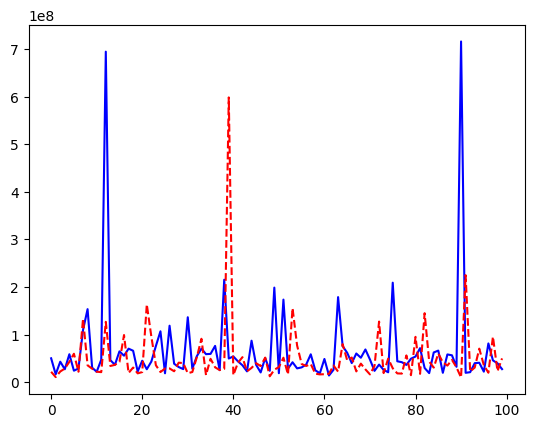

In [9]:
mp.plot_model_prediction_in_actual_data("Model_Straight2_ReLU_Drop0.2_Adam_MSE_.pt")

In [2]:
model = torch.load("savedModels/Model_Funnel1_ELU_Drop0.0_Adam_MAPE_.pt")
model.eval()

Model_Funnel1(
  (activation): ELU(alpha=1.0)
  (inputLayer): Linear(in_features=9467, out_features=18934, bias=True)
  (activationLayer): ELU(alpha=1.0)
  (dropout): Dropout(p=0.0, inplace=False)
  (hiddenLayer1): Linear(in_features=18934, out_features=1577, bias=True)
  (outputLayer): Linear(in_features=1577, out_features=1, bias=True)
)